In [7]:
# Included Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier,
                             GradientBoostingClassifier)
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix)
from scipy import stats
from dataclasses import dataclass
from typing import Dict, Tuple, List

## Data Preprocessing and Cleanup

In [8]:
# loading the dataset

df = pd.read_csv("data.csv")
df.head()


,tech_company,benefits,workplace_resources,mh_employer_discussion,mh_coworker_discussion,medical_coverage,mental_health,mh_share,age,gender,country
0,Yes,No,I don't know,No,Yes,Yes,Possibly,5,27.0,Female,United Kingdom
1,Yes,Yes,No,No,Yes,Yes,Possibly,4,31.0,Male,United Kingdom
2,Yes,I don't know,No,Yes,Yes,No,Yes,5,36.0,Male,United States of America
3,Yes,Yes,I don't know,Yes,Yes,Yes,Yes,10,22.0,Male,United States of America
4,Yes,Yes,No,No,Yes,Yes,Yes,8,36.0,Female,United States of America


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tech_company            1242 non-null   object 
 1   benefits                1242 non-null   object 
 2   workplace_resources     1242 non-null   object 
 3   mh_employer_discussion  1242 non-null   object 
 4   mh_coworker_discussion  1242 non-null   object 
 5   medical_coverage        1242 non-null   object 
 6   mental_health           1242 non-null   object 
 7   mh_share                1242 non-null   int64  
 8   age                     1242 non-null   float64
 9   gender                  1242 non-null   object 
 10  country                 1242 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 106.9+ KB
None


In [10]:
# Filter for Tech Employees only
df = df[df['tech_company'] == "Yes"]

In [11]:
df.shape

(899, 11)

In [12]:
# Keep only relevant columns

df = df[['workplace_resources','mh_employer_discussion','medical_coverage',
         'mh_share','gender','age']]

In [13]:
# Drop missing values

df = df.dropna()

In [14]:
# Data Preparation

df['high_comfort'] = np.where(df['mh_share'] >= 7, 1, 0)

In [15]:
# Encode predictors

df['resources_binary'] = df['workplace_resources'].map({'Yes':1,'No':0})
# -1 for "I don't know"
df['resources_binary'] = df['resources_binary'].fillna(-1)

df['employer_binary'] = df['mh_employer_discussion'].map({'Yes':1,'No':0})
df['employer_binary'] = df['employer_binary'].fillna(-1)

df['coverage_binary']  = df['medical_coverage'].map({'Yes':1,'No':0})
df['coverage_binary']  = df['coverage_binary'].fillna(-1)

In [16]:
## Engineered variable: Combined support

df['combined_support'] = ((df['resources_binary'] +
                           df['employer_binary'] +
                           df['coverage_binary']) >= 2).astype(int)

print("Dataset shape after cleaning:", df.shape)
print(df.head())

Dataset shape after cleaning: (899, 11)
  workplace_resources mh_employer_discussion medical_coverage  mh_share  \
0        I don't know                     No              Yes         5   
1                  No                     No              Yes         4   
2                  No                    Yes               No         5   
3        I don't know                    Yes              Yes        10   
4                  No                     No              Yes         8   

   gender   age  high_comfort  resources_binary  employer_binary  \
0  Female  27.0             0              -1.0                0   
1    Male  31.0             0               0.0                0   
2    Male  36.0             0               0.0                1   
3    Male  22.0             1              -1.0                1   
4  Female  36.0             1               0.0                0   

   coverage_binary  combined_support  
0                1                 0  
1                1    

In [17]:
# Encode gender as binary for modeling (Female=1, Male=0, Others=-1)
df['gender_binary'] = df['gender'].map({'Female':1, 'Male':0}).fillna(-1)

# Normalize age
df['age_scaled'] = (df['age'] - df['age'].mean()) / df['age'].std()

## Descriptive Analysis

In [18]:
# Display the descriptive statistices of the cleaned data
df.describe()

,mh_share,age,high_comfort,resources_binary,employer_binary,coverage_binary,combined_support,gender_binary,age_scaled
count,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,8.990000e+02
mean,6.667408,34.638487,0.590656,0.036707,0.361513,0.915462,0.430478,0.259177,2.568703e-16
std,2.624952,7.850745,0.491986,0.776742,0.480706,0.278348,0.495419,0.530382,1.000000e+00
min,0.000000,19.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,-1.991975e+00
25%,5.000000,29.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,-7.182105e-01
50%,7.000000,34.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-8.132823e-02
75%,9.000000,40.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.829305e-01
max,10.000000,65.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.867342e+00


In [47]:
# Exploratory Data Analysis (EDA)
# Function to add percentages on bar plots
def plot_count_with_pct(x, hue, title):
    ax = sns.countplot(x=x, hue=hue, data=df, palette="Set2")
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{100*height/total:.1f}%',
                    (p.get_x() + p.get_width()/2, height),
                    ha='center', va='bottom', fontsize=9)
    plt.title(title)
    plt.xlabel(x.replace('_', ' ').replace('mh', 'Mental Health').title())
    plt.ylabel("Frequency")
    plt.legend(title="High Comfort", labels=["No (0)", "Yes (1)"])
    plt.show()

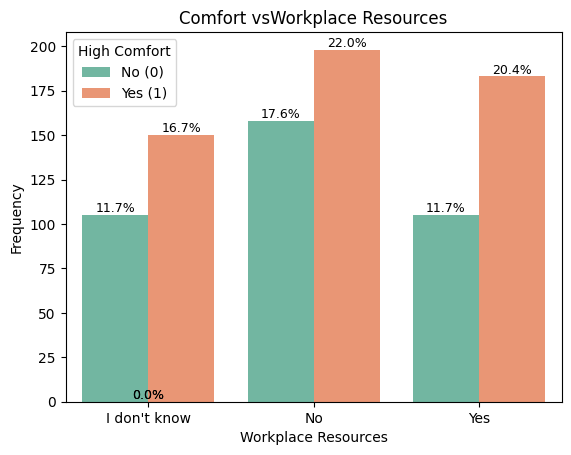

In [49]:
plot_count_with_pct("workplace_resources","high_comfort","Comfort vs"
                    "Workplace Resources")

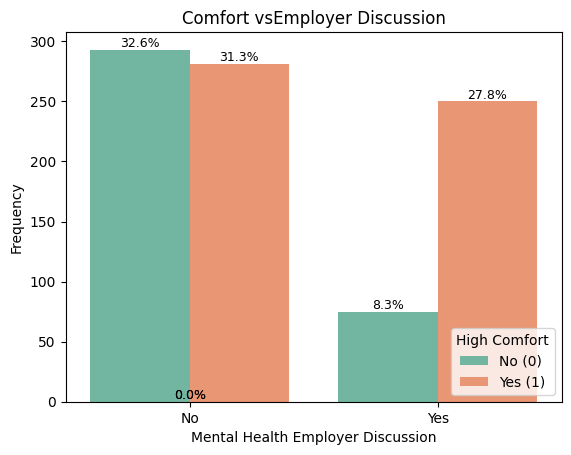

In [50]:
plot_count_with_pct("mh_employer_discussion","high_comfort","Comfort vs"
                    "Employer Discussion")

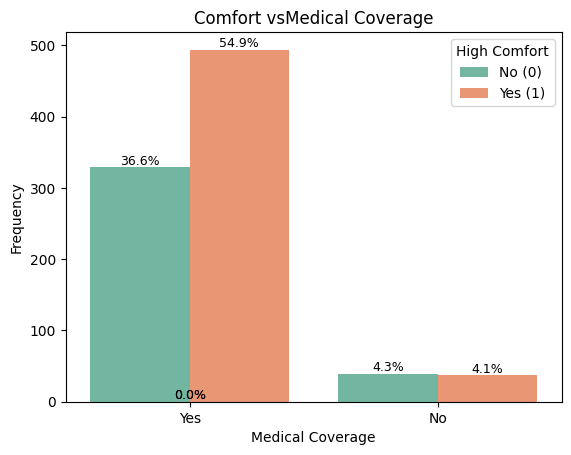

In [51]:
plot_count_with_pct("medical_coverage","high_comfort","Comfort vs"
                    "Medical Coverage")

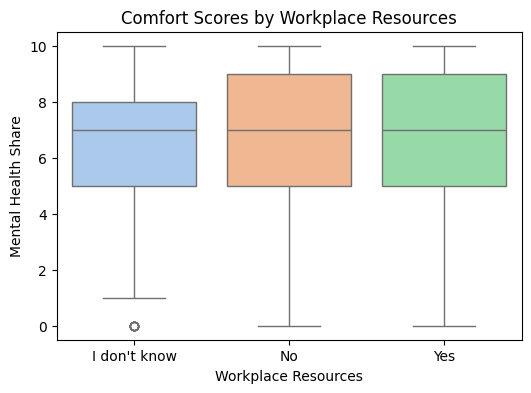

In [20]:
# Boxplot comfort levels
plt.figure(figsize=(6,4))
sns.boxplot(x="workplace_resources", y="mh_share", data=df,
            hue="workplace_resources", palette="pastel",legend=False)
plt.ylabel('Mental Health Share')
plt.xlabel("workplace_resources".replace('_', ' ')
                                .replace('mh', 'Mental Health').title())
plt.title("Comfort Scores by Workplace Resources")
plt.show()

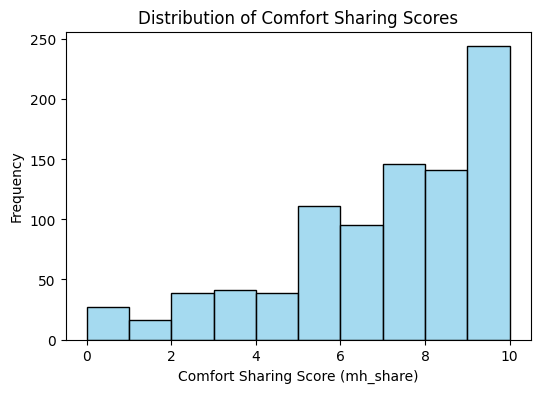

In [21]:
# Histogram distribution
plt.figure(figsize=(6,4))
sns.histplot(df['mh_share'], bins=10, kde=False, color="skyblue")
plt.title("Distribution of Comfort Sharing Scores")
plt.xlabel("Comfort Sharing Score (mh_share)")
plt.ylabel("Frequency")
plt.show()

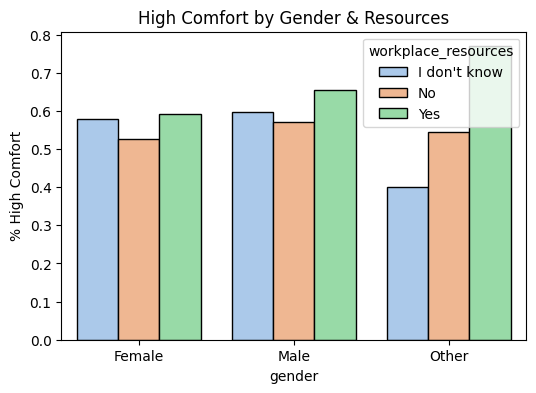

In [22]:
# Stratified by gender
plt.figure(figsize=(6,4))
sns.barplot(x="gender", y="high_comfort", hue="workplace_resources",
            data=df, errorbar=None, palette="pastel", edgecolor="black")
plt.title("High Comfort by Gender & Resources")
plt.ylabel("% High Comfort")
plt.show()

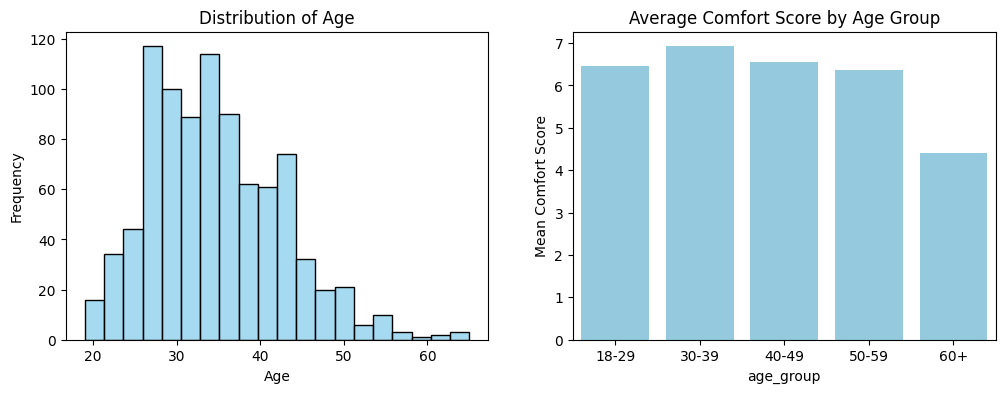

In [23]:
# Histogram of Age
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['age'], bins=20, color="skyblue", edgecolor='black')
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
df['age_group'] = pd.cut(df['age'], bins=[18,30,40,50,60,80],
                         labels=["18-29","30-39","40-49","50-59","60+"])
sns.barplot(x="age_group", y="mh_share", data=df,
            color="skyblue", errorbar=None)
plt.title("Average Comfort Score by Age Group")
plt.ylabel("Mean Comfort Score")
plt.show()

In [24]:
# Average Comfort Score by Age Group


## Independent T-Test

In [25]:
# Calculate Confidence interval for the Mean Difference
def get_confidence_interval(yes, no) -> tuple[float, float, float]:
    # Retrieve the mean of the two groups
    mean_diff = yes.mean() - no.mean()
    # Compute standard error
    se = np.sqrt(yes.var(ddof=1)/len(yes) + no.var(ddof=1)/len(no))
    # Calculate the 95% confidence interval
    ci_low, ci_high = mean_diff - 1.96*se, mean_diff + 1.96*se
    return mean_diff, ci_low, ci_high

In [26]:
# Statistical Testing : Perform Welch's Independent T-Test
def welch_test(df, col1, col2, label):
    # Extract the data for the two comparing columns
    yes = df.loc[df[col1] == 1, col2].values
    no = df.loc[df[col1] == 0, col2].values
    # Perform Welch's T-Test
    t_stat, p_val = stats.ttest_ind(yes, no, equal_var=False)
    # Retrieve the significance test stats
    mean_diff, ci_low, ci_high = get_confidence_interval(yes, no)
    return {
            "Variable": label,
            "t(df)": f"{t_stat:.3f}",
            "p": p_val,
            "Mean Diff": f"{mean_diff:.2f}",
            "95% CI": f"[{ci_low:.2f}, {ci_high:.2f}]",
            "Significance": "Sig." if p_val < 0.05 else "Not Sig."
        }

In [27]:
# Perfrom T-Test on all six predictors
rows = []
rows.append(welch_test(df, "resources_binary", "mh_share",
                      "Resources Binary"))
rows.append(welch_test(df, "employer_binary", "mh_share",
                       "Employer Discussion"))
rows.append(welch_test(df, "coverage_binary", "mh_share",
                       "Coverage Binary"))
table = pd.DataFrame(rows, columns=["Variable", "t(df)", "p", "Mean Diff",
                                    "95% CI", "Significance"])

# Report Test Results for all six predictors
display(table.style.set_caption("Table 3. Independent Samples t-Tests for"
                                "Mental Health Sharing (mh_share)"))

,Variable,t(df),p,Mean Diff,95% CI,Significance
0,Resources Binary,1.872,0.061600,0.39,"[-0.02, 0.79]",Not Sig.
1,Employer Discussion,8.508,0.000000,1.46,"[1.12, 1.79]",Sig.
2,Coverage Binary,1.559,0.122543,0.50,"[-0.13, 1.13]",Not Sig.


## Logistic Regression Model

In [28]:
# Structures to store Test and Train Set Results
probs_test, preds_test = {}, {}
probs_train, preds_train = {}, {}

In [29]:
# Print Model Information
def evaluate_model(y_test, y_pred, y_prob, model_name, total = 0):
    if total == 0:
        print(f"\n{model_name} Regression Performance:")
        print("Accuracy:", round(accuracy_score(y_test,y_pred),4))
        print("Precision:", round(precision_score(y_test,y_pred),4))
        print("Recall:", round(recall_score(y_test,y_pred),4))
        print("F1 Score:", round(f1_score(y_test,y_pred),4))
        print("AUC:", round(roc_auc_score(y_test,y_prob),4))

### Baseline Logistic Regression

In [30]:
# Baseline Logistic Regression
model_name = "Baseline Logistic"

# Test-Train Split
# Split the data into training and testing sets (80% train, 20% test)
X1 = df[['resources_binary']].dropna()
y = df["high_comfort"].astype(int).copy()
X_train, X_test, y_train, y_test = train_test_split(
    X1, y, test_size=0.2, stratify=y, random_state=42
)

# Fit Logistic Regression Model on the training data
logit1 = LogisticRegression(max_iter=1000)
logit1.fit(X_train, y_train)

# Predict Train and Test Sets
# Predict binary class and probabilities labels for test set
pred_test1 = logit1.predict(X_test)
prob_test1 = logit1.predict_proba(X_test)[:,1]
pred_train1 = logit1.predict(X_train)
prob_train1 = logit1.predict_proba(X_train)[:,1]

# Store Train and Test Set Results
probs_train[model_name] = prob_train1
preds_train[model_name] = pred_train1
probs_test[model_name] = prob_test1
preds_test[model_name] = pred_test1

# Display Test Set Result
evaluate_model(y_test, pred_test1, prob_test1, model_name)


Baseline Logistic Regression Performance:
Accuracy: 0.5889
Precision: 0.5889
Recall: 1.0
F1 Score: 0.7413
AUC: 0.5091


### Improved Logistic Regression

In [31]:
# Improved Logistic Regression (with demographics)
model_name = "Improved Logistic"

# Test-Train Split for all 6 predictors
# Split the data into training and testing sets (80% train, 20% test)
X2 = df[['resources_binary','employer_binary','coverage_binary',
         'combined_support','gender_binary','age_scaled']]
X_train, X_test, y_train, y_test = train_test_split(
    X2,y,test_size=0.2,stratify=y,random_state=42
)

# Fit the Improved Logistic Regression Model on the training data
logit2 = LogisticRegression(max_iter=1000)
logit2.fit(X_train,y_train)

# Predict Train and Test Sets
# Predict binary class and probabilities labels for test set
pred_test2 = logit2.predict(X_test)
prob_test2 = logit2.predict_proba(X_test)[:,1]
pred_train2 = logit2.predict(X_train)
prob_train2 = logit2.predict_proba(X_train)[:,1]

# Store Train and Test Set Results
probs_train[model_name] = prob_train2
preds_train[model_name] = pred_train2
probs_test[model_name] = prob_test2
preds_test[model_name] = pred_test2

# Display Test Set Result
evaluate_model(y_test, pred_test2, prob_test2, model_name)


Improved Logistic Regression Performance:
Accuracy: 0.6111
Precision: 0.6579
Recall: 0.7075
F1 Score: 0.6818
AUC: 0.6638


In [32]:
def pred_summary(X: pd.DataFrame, y: pd.Series):
        Xc = sm.add_constant(X)
        logit = sm.Logit(y, Xc)
        result = logit.fit(disp=False)
        summ = result.summary2().tables[1].copy()
        summ = summ.rename(columns={"Coef.": "β", "Std.Err.": "SE", "P>|z|"
                                    : "p", "[0.025": "CI Low", "0.975]"
                                    :"CI High"})
        summ["OR"] = np.exp(summ["β"])
        # Order columns
        summ = summ[["β", "SE", "OR", "CI Low", "CI High", "p"]]
        return summ.round(3), result

In [33]:
# Logistic Regression Coefficients
predictors = list(X_train.columns)
coefficients = pd.DataFrame({
    'Predictor': predictors,
    'Coefficient': logit2.coef_[0]
})
coefficients['Odds_Ratio'] = np.exp(coefficients['Coefficient'])
coefficients.sort_values(by='Odds_Ratio', ascending=False, inplace=True)
display(coefficients.style.set_caption("Table 4. Logistic Regression"
                                       "Coefficients and Odds Ratios "))

sm_table, sm_result = pred_summary(X_train, y_train)
display(sm_table.style.set_caption("Table 5. Predictor Logit"
                                   "Estimates (Train Set)"))

,Predictor,Coefficient,Odds_Ratio
1,employer_binary,1.102152,3.010638
3,combined_support,0.279205,1.322079
2,coverage_binary,0.180056,1.197284
5,age_scaled,0.038992,1.039762
0,resources_binary,-0.127057,0.880684
4,gender_binary,-0.162154,0.850310


,β,SE,OR,CI Low,CI High,p
const,-0.238000,0.274000,0.788000,-0.775000,0.299000,0.385000
resources_binary,-0.124000,0.178000,0.883000,-0.473000,0.224000,0.485000
employer_binary,1.144000,0.211000,3.139000,0.729000,1.558000,0.000000
coverage_binary,0.196000,0.298000,1.216000,-0.388000,0.779000,0.511000
combined_support,0.262000,0.324000,1.300000,-0.373000,0.898000,0.419000
gender_binary,-0.167000,0.149000,0.846000,-0.459000,0.124000,0.261000
age_scaled,0.039000,0.080000,1.040000,-0.117000,0.196000,0.623000


### Random Forest Model

In [34]:
# Supporting Model: Random Forest
model_name = "Random Forest"

# Fit Random Forest Model
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced",
                            random_state=42)
rf.fit(X_train,y_train)

# Predict Train and Test Sets
pred_test3 = rf.predict(X_test)
prob_test3 = rf.predict_proba(X_test)[:,1]
pred_train3 = rf.predict(X_train)
prob_train3 = rf.predict_proba(X_train)[:,1]

# Store Train and Test Set Results
probs_train[model_name] = prob_train3
preds_train[model_name] = pred_train3
probs_test[model_name] = prob_test3
preds_test[model_name] = pred_test3

# Display Test Set Result
evaluate_model(y_test, pred_test3, prob_test3, model_name)


Random Forest Regression Performance:
Accuracy: 0.5167
Precision: 0.5922
Recall: 0.5755
F1 Score: 0.5837
AUC: 0.5388


### Gradient Boosting Model

In [35]:
# Supporting Model: Gradient Boosting
model_name = "Gradient Boosting"

# Fit Gradient Boosting Model on the training data
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05,
                                random_state=42)
gb.fit(X_train,y_train)

# Predict Train and Test Sets
# Predict binary class and probabilities labels for test set
pred_test4 = gb.predict(X_test)
prob_test4 = gb.predict_proba(X_test)[:,1]
pred_train4 = gb.predict(X_train)
prob_train4 = gb.predict_proba(X_train)[:,1]

# Store Train and Test Set Results
probs_train[model_name] = prob_train4
preds_train[model_name] = pred_train4
probs_test[model_name] = prob_test4
preds_test[model_name] = pred_test4

# Display Test Set Result
evaluate_model(y_test, pred_test4, prob_test4, model_name)


Gradient Boosting Regression Performance:
Accuracy: 0.6056
Precision: 0.6316
Recall: 0.7925
F1 Score: 0.7029
AUC: 0.6015


### Model Analysis

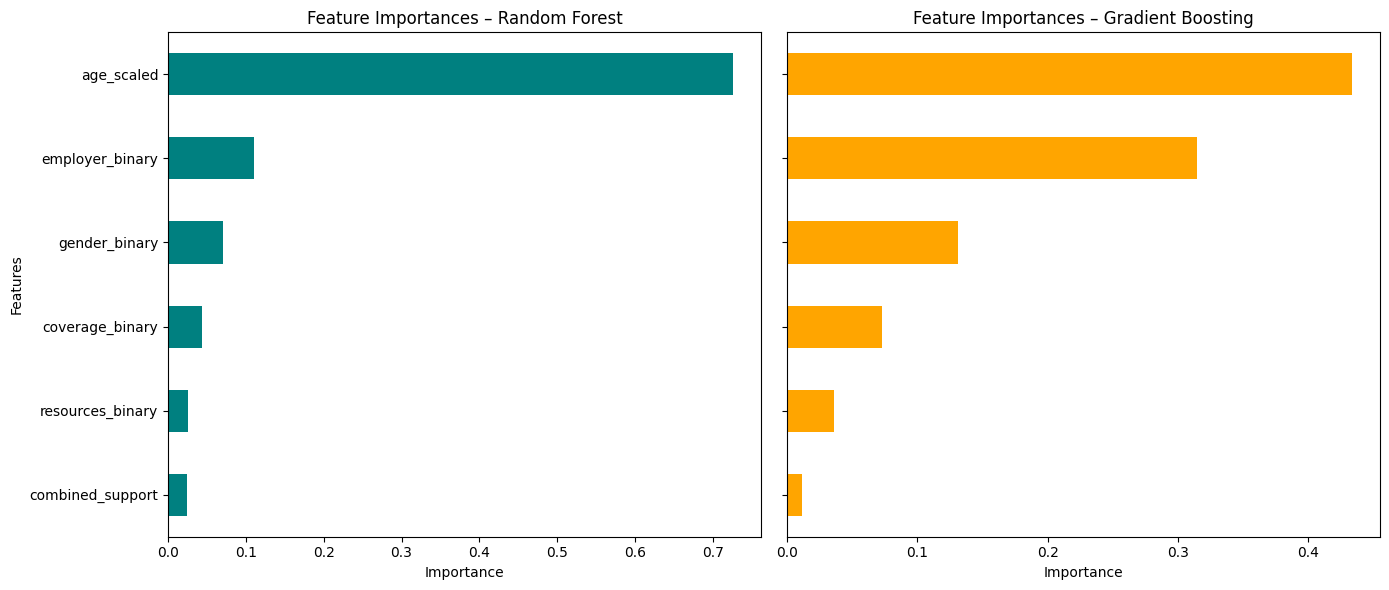

In [36]:
# Feature Importance
# Create a pandas series for the feature importances
# This gives each feature's contribution to the model
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
gb_importances = pd.Series(gb.feature_importances_, index=X_train.columns)

# Set up figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Random Forest plot
rf_importances.sort_values().plot(
    kind="barh", color="teal", ax=axes[0]
)
axes[0].set_title("Feature Importances – Random Forest", fontsize=12)
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Features")

# Gradient Boosting plot
gb_importances.sort_values().plot(
    kind="barh", color="orange", ax=axes[1]
)
axes[1].set_title("Feature Importances – Gradient Boosting", fontsize=12)
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("")  # Hide duplicate y-labels

# Adjust layout and display importance plots
plt.tight_layout()
plt.show()

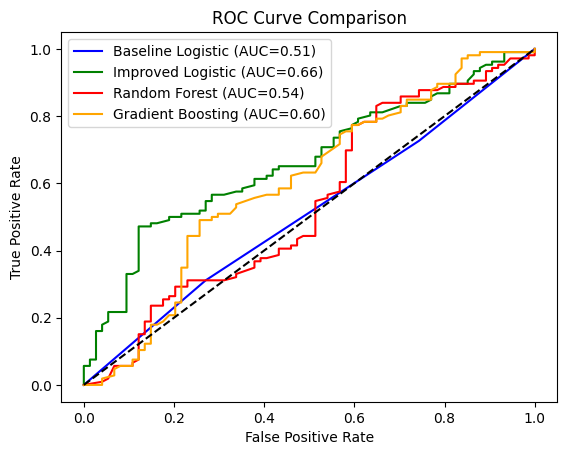

In [37]:
# ROC Comparison
# Calculate the false positive rates, true postitive rate and the thresholds for each model
fpr1,tpr1,_ = roc_curve(y_test,prob_test1)
fpr2,tpr2,_ = roc_curve(y_test,prob_test2)
fpr_rf,tpr_rf,_ = roc_curve(y_test,prob_test3)
fpr_gb,tpr_gb,_ = roc_curve(y_test,prob_test4)

# Plot ROC Curves for each of the models
plt.plot(fpr1,tpr1,label=f"Baseline Logistic (AUC="
                      f"{roc_auc_score(y_test,prob_test1):.2f})",
                         color="blue")
plt.plot(fpr2,tpr2,label=f"Improved Logistic (AUC="
                      f"{roc_auc_score(y_test,prob_test2):.2f})",
                         color="green")
plt.plot(fpr_rf,tpr_rf,label=f"Random Forest (AUC="
                      f"{roc_auc_score(y_test,prob_test3):.2f})",
                         color="red")
plt.plot(fpr_gb,tpr_gb,label=f"Gradient Boosting (AUC="
                      f"{roc_auc_score(y_test,prob_test4):.2f})",
                         color="orange")

# Plot the lines for random guess and reference
plt.plot([0,1],[0,1],"k--")

# Set the axes lables and titles
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")

# Assign legend and display the plots
plt.legend()
plt.show()

In [38]:
def plot_confusion_matrices(
        y_true: pd.Series, preds: Dict[str, np.ndarray]
    ):
        fig, axes = plt.subplots(2, 2, figsize=(14, 8))
        axes = axes.flatten()  # Flatten for easier iteration

        for ax, (model_name, y_pred) in zip(axes, preds.items()):
            cm = confusion_matrix(y_true, y_pred)
            acc = accuracy_score(y_true, y_pred)

            # Heatmap with gridlines between cells
            sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                cbar=True,
                ax=ax,
                linewidths=1,
                linecolor="black",
                square=True,
                xticklabels=["Pred: Low","Pred: High"],
                yticklabels=["True: Low","True: High"]
            )

            ax.set_title(f"{model_name}\nAccuracy = {acc:.2f}",
                         fontsize=11, pad=8)
            ax.set_xlabel("Predicted Label")
            ax.set_ylabel("True Label")
            ax.tick_params(axis='x', labelrotation=45)
            ax.tick_params(axis='y', labelrotation=0)

        fig.add_artist(plt.Line2D((0.5, 0.5), (0, 1), color='black',
                                  linewidth=2,
                                  transform=fig.transFigure, zorder=10))
        fig.add_artist(plt.Line2D((0, 1), (0.5, 0.5), color='black',
                                  linewidth=2,
                                  transform=fig.transFigure, zorder=10))
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.tight_layout()
        plt.show()

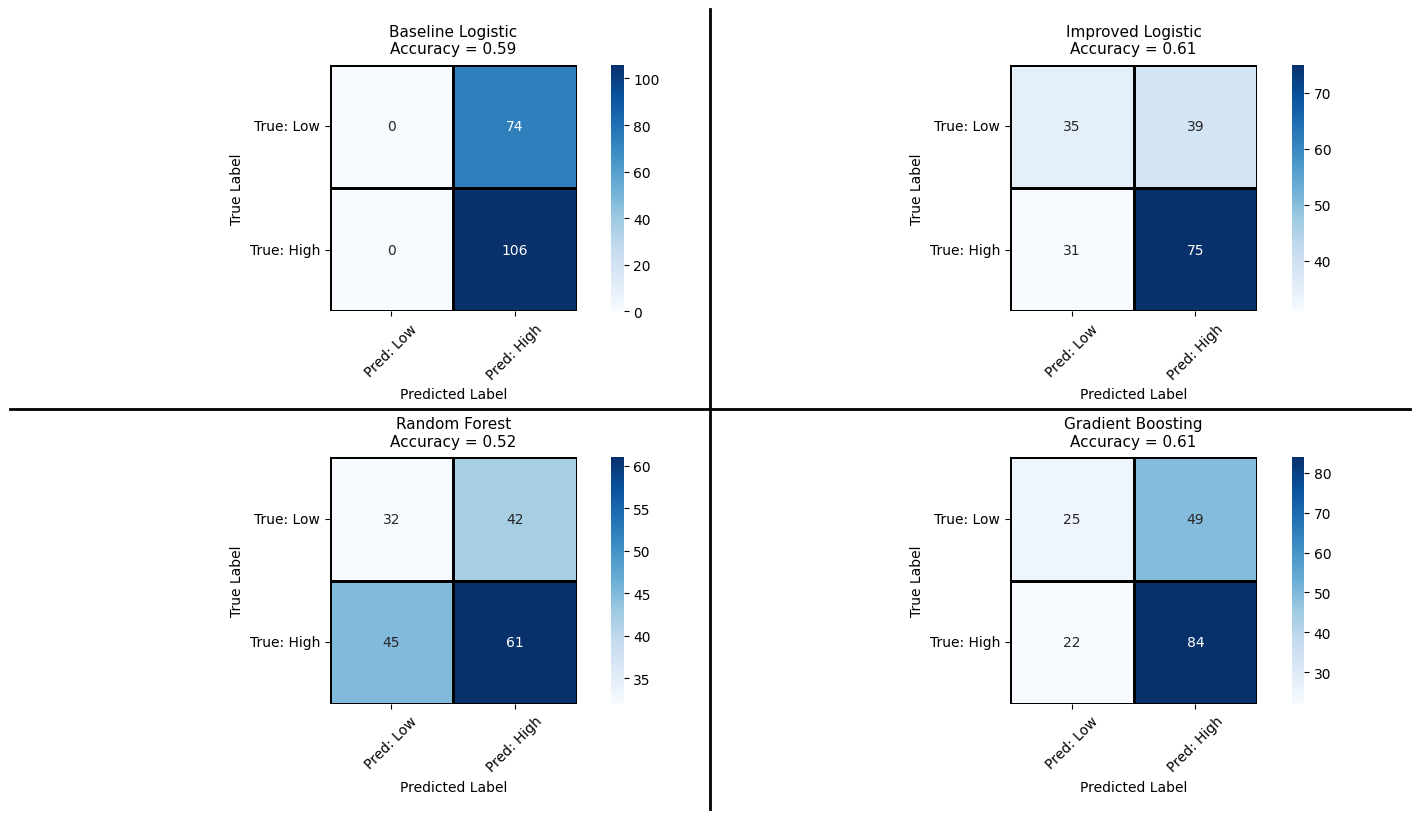

In [39]:
plot_confusion_matrices(y_test, preds_test)

In [40]:
# Train vs Test summaries
def performance_table(
         y_true: pd.Series, probs: Dict[str, np.ndarray],
         preds: Dict[str, np.ndarray]
    ) -> pd.DataFrame:
        rows = []
        # Loop through each model name and retrieve classification metrics
        for name in probs.keys():
            row = {
                "Model": name,
                "Accuracy": accuracy_score(y_true, preds[name]),
                "Precision": precision_score(y_true, preds[name],
                                             zero_division=0),
                "Recall": recall_score(y_true, preds[name], zero_division=0),
                "F1": f1_score(y_true, preds[name], zero_division=0),
                "AUC": roc_auc_score(y_true, probs[name]),
            }
            rows.append(row)
        df = pd.DataFrame(rows).sort_values("AUC", ascending=False)
        return (df[["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]]
               .round(3).reset_index(drop=True))

In [41]:
# Model Performance Summary
# Train Set
train_table = performance_table(y_train, probs_train, preds_train)
# Test Set
test_table = performance_table(y_test, probs_test, preds_test)

# Display both train and test set tables
display(train_table.style.set_caption("Model Comparison Summary "
                                      "— Train Set").format(precision=3))
display(test_table.style.set_caption("Model Comparison Summary "
                                     "— Test Set").format(precision=3))


,Model,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.812,0.855,0.821,0.838,0.908
1,Gradient Boosting,0.718,0.720,0.854,0.781,0.790
2,Improved Logistic,0.627,0.669,0.732,0.699,0.660
3,Baseline Logistic,0.591,0.591,1.000,0.743,0.525


,Model,Accuracy,Precision,Recall,F1,AUC
0,Improved Logistic,0.611,0.658,0.708,0.682,0.664
1,Gradient Boosting,0.606,0.632,0.792,0.703,0.602
2,Random Forest,0.517,0.592,0.575,0.584,0.539
3,Baseline Logistic,0.589,0.589,1.000,0.741,0.509


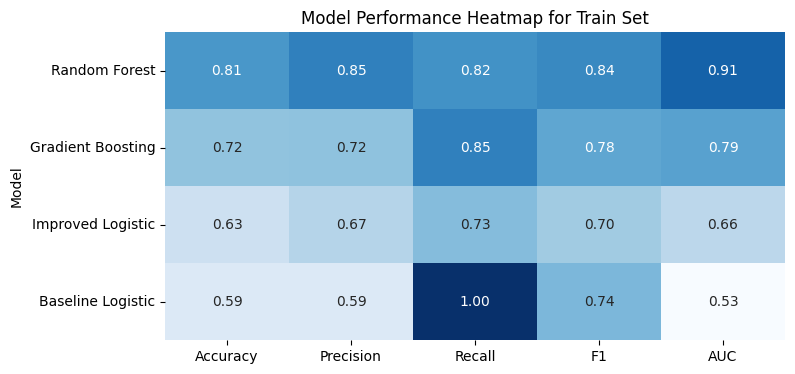

In [42]:
# Display the heatmap for the train set
plt.figure(figsize=(8,4))
sns.heatmap(train_table.set_index("Model"), annot=True, fmt=".2f",
            cmap="Blues", cbar=False)
plt.title("Model Performance Heatmap for Train Set")
plt.show()

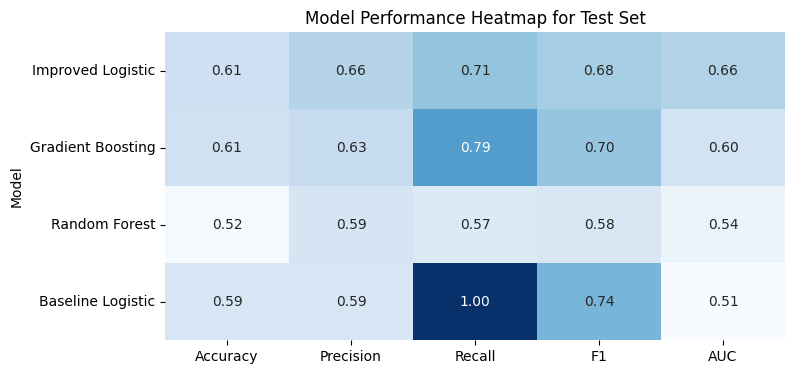

In [43]:
# Display the heatmap for the test set
plt.figure(figsize=(8,4))
sns.heatmap(test_table.set_index("Model"), annot=True, fmt=".2f",
            cmap="Blues", cbar=False)
plt.title("Model Performance Heatmap for Test Set")
plt.show()

In [44]:
# Cross-Validation

cv_scores = cross_val_score(LogisticRegression(max_iter=1000), X2, y, cv=5,
                            scoring="roc_auc")
print(f"\nCross-validated AUC for Improved Logistic Regression: "
      f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

cv_scores_gb = cross_val_score(GradientBoostingClassifier(n_estimators=200,
                                                         learning_rate=0.05,
                                                         random_state=42),
                               X2, y, cv=5, scoring="roc_auc")
print(f"Cross-validated AUC for Gradient Boosting: {cv_scores_gb.mean():.3f} "
      f"± {cv_scores_gb.std():.3f}")


Cross-validated AUC for Improved Logistic Regression: 0.636 ± 0.014
Cross-validated AUC for Gradient Boosting: 0.630 ± 0.023
